In [ ]:
!pip install networkx pulp gurobipy ortools matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
import numpy as np
import pandas as pd
import pulp as pl
from scipy.stats import norm

def optimize_portfolio(expected_returns, covariance_matrix, risk_tolerance=None, target_return=None,
                      max_position=0.4, min_position=0, risk_free_rate=0.02):
    """
    Optimize a portfolio using PuLP with different optimization objectives.

    Parameters:
    -----------
    expected_returns : pd.Series or list
        Expected returns for each asset
    covariance_matrix : pd.DataFrame or np.array
        Covariance matrix of returns
    risk_tolerance : float, optional
        Risk aversion parameter for utility maximization
    target_return : float, optional
        Target return for minimum variance optimization
    max_position : float, default 0.4
        Maximum weight for any asset
    min_position : float, default 0
        Minimum weight for any asset
    risk_free_rate : float, default 0.02
        Risk-free rate for Sharpe ratio calculation

    Returns:
    --------
    dict
        Dictionary with optimization results
    """
    # Ensure inputs are in the right format
    if isinstance(expected_returns, list):
        expected_returns = np.array(expected_returns)
    if isinstance(covariance_matrix, list):
        covariance_matrix = np.array(covariance_matrix)

    n_assets = len(expected_returns)
    assets = range(n_assets)

    # For Maximum Sharpe Ratio, we need to use a different approach
    # We'll sample different target returns and choose the one with highest Sharpe
    if target_return is None and risk_tolerance is None:
        best_sharpe = -np.inf
        optimal_weights = None
        min_return = min(expected_returns)
        max_return = max(expected_returns)

        # Sample different target returns and solve
        for target in np.linspace(min_return, max_return, 100):
            # Create a minimum variance portfolio with this target return
            result = optimize_portfolio(
                expected_returns,
                covariance_matrix,
                risk_tolerance=None,
                target_return=target,
                max_position=max_position,
                min_position=min_position,
                risk_free_rate=risk_free_rate
            )

            if result["status"] == "Optimal":
                sharpe = result["sharpe_ratio"]
                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    optimal_weights = result["weights"]
                    optimal_return = result["expected_return"]
                    optimal_risk = result["expected_risk"]

        if optimal_weights is not None:
            return {
                "weights": optimal_weights,
                "objective_type": "Maximum Sharpe Ratio",
                "expected_return": optimal_return,
                "expected_risk": optimal_risk,
                "sharpe_ratio": best_sharpe,
                "status": "Optimal"
            }
        else:
            return {"status": "No feasible solution found"}

    # Initialize the optimization problem
    if target_return is not None:
        # Minimize variance given a target return
        prob = pl.LpProblem("Portfolio_Min_Variance", pl.LpMinimize)
        objective_type = "Minimum Variance with Target Return"
    elif risk_tolerance is not None:
        # Maximize utility (mean - risk_tolerance * variance)
        # This is tricky to implement directly in PuLP due to quadratic terms
        # We'll approximate it by trying different target returns
        best_utility = -np.inf
        optimal_weights = None
        min_return = min(expected_returns)
        max_return = max(expected_returns)

        # Sample different target returns and calculate utility
        for target in np.linspace(min_return, max_return, 100):
            # Create a minimum variance portfolio with this target return
            result = optimize_portfolio(
                expected_returns,
                covariance_matrix,
                risk_tolerance=None,
                target_return=target,
                max_position=max_position,
                min_position=min_position,
                risk_free_rate=risk_free_rate
            )

            if result["status"] == "Optimal":
                # Calculate utility: return - risk_aversion * variance
                utility = result["expected_return"] - risk_tolerance * (result["expected_risk"]**2)
                if utility > best_utility:
                    best_utility = utility
                    optimal_weights = result["weights"]
                    optimal_return = result["expected_return"]
                    optimal_risk = result["expected_risk"]
                    optimal_sharpe = result["sharpe_ratio"]

        if optimal_weights is not None:
            return {
                "weights": optimal_weights,
                "objective_type": "Utility Maximization",
                "expected_return": optimal_return,
                "expected_risk": optimal_risk,
                "sharpe_ratio": optimal_sharpe,
                "utility": best_utility,
                "status": "Optimal"
            }
        else:
            return {"status": "No feasible solution found"}

    # Create decision variables for asset weights
    weights = [pl.LpVariable(f"Asset_{i}", min_position, max_position) for i in assets]

    # Constraint: Sum of weights = 1
    prob += pl.lpSum(weights) == 1, "Sum_of_weights"

    # For minimum variance with target return
    # We can't directly express quadratic terms in PuLP's objective
    # Instead, we'll use a common approach: minimize a linear approximation of risk

    # Create auxiliary variables for the absolute values of weights
    aux_vars = [pl.LpVariable(f"aux_{i}", 0, None) for i in assets]

    # Create an approximation of risk using the diagonal of covariance matrix
    # This isn't perfect but is a linear approximation that PuLP can handle
    risk_proxy = pl.lpSum([aux_vars[i] * np.sqrt(covariance_matrix[i, i]) for i in assets])

    # Set the auxiliary variables to be greater than or equal to the absolute values
    for i in assets:
        prob += aux_vars[i] >= weights[i], f"abs_constraint_pos_{i}"
        prob += aux_vars[i] >= -weights[i], f"abs_constraint_neg_{i}"

    # Minimize the risk proxy
    prob += risk_proxy, "Risk_Proxy"

    # Constraint: Achieve target return
    prob += pl.lpSum([weights[i] * expected_returns[i] for i in assets]) >= target_return, "Target_Return"

    # Solve the optimization problem
    prob.solve(pl.PULP_CBC_CMD(msg=False))

    # Process results
    if prob.status == 1:  # Optimal solution found
        solution_weights = [weights[i].value() for i in assets]

        # Calculate true portfolio return and risk with the solved weights
        portfolio_return = sum(solution_weights[i] * expected_returns[i] for i in assets)

        # Calculate the true risk using the full covariance matrix
        portfolio_var = 0
        for i in assets:
            for j in assets:
                portfolio_var += solution_weights[i] * covariance_matrix[i, j] * solution_weights[j]
        portfolio_std = np.sqrt(portfolio_var)

        sharpe = (portfolio_return - risk_free_rate) / portfolio_std

        return {
            "weights": solution_weights,
            "objective_type": objective_type,
            "expected_return": portfolio_return,
            "expected_risk": portfolio_std,
            "sharpe_ratio": sharpe,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found"}


# Example usage
if __name__ == "__main__":
    # Example data
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK-B']
    expected_returns = np.array([0.12, 0.10, 0.15, 0.11, 0.09])

    # Create a sample covariance matrix (typically from historical data)
    # This is just an example - in practice, you'd calculate this from actual returns
    corr_matrix = np.array([
        [1.00, 0.60, 0.50, 0.70, 0.25],
        [0.60, 1.00, 0.45, 0.65, 0.30],
        [0.50, 0.45, 1.00, 0.55, 0.20],
        [0.70, 0.65, 0.55, 1.00, 0.35],
        [0.25, 0.30, 0.20, 0.35, 1.00]
    ])
    volatilities = np.array([0.25, 0.20, 0.30, 0.22, 0.15])
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix

    # Run optimizations
    # 1. Minimum variance with target return
    min_var_portfolio = optimize_portfolio(
        expected_returns,
        cov_matrix,
        target_return=0.12
    )

    # 2. Utility maximization
    utility_portfolio = optimize_portfolio(
        expected_returns,
        cov_matrix,
        risk_tolerance=2.0
    )

    # 3. Maximum Sharpe ratio
    max_sharpe_portfolio = optimize_portfolio(
        expected_returns,
        cov_matrix
    )

    # Print results
    print("\n--- Minimum Variance Portfolio (Target Return: 12%) ---")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {min_var_portfolio['weights'][i]*100:.2f}%")
    print(f"Expected Return: {min_var_portfolio['expected_return']*100:.2f}%")
    print(f"Expected Risk: {min_var_portfolio['expected_risk']*100:.2f}%")
    print(f"Sharpe Ratio: {min_var_portfolio['sharpe_ratio']:.4f}")

    print("\n--- Utility Maximization Portfolio (Risk Aversion: 2.0) ---")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {utility_portfolio['weights'][i]*100:.2f}%")
    print(f"Expected Return: {utility_portfolio['expected_return']*100:.2f}%")
    print(f"Expected Risk: {utility_portfolio['expected_risk']*100:.2f}%")
    print(f"Sharpe Ratio: {utility_portfolio['sharpe_ratio']:.4f}")

    print("\n--- Maximum Sharpe Ratio Portfolio ---")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {max_sharpe_portfolio['weights'][i]*100:.2f}%")
    print(f"Expected Return: {max_sharpe_portfolio['expected_return']*100:.2f}%")
    print(f"Expected Risk: {max_sharpe_portfolio['expected_risk']*100:.2f}%")
    print(f"Sharpe Ratio: {max_sharpe_portfolio['sharpe_ratio']:.4f}")


--- Minimum Variance Portfolio (Target Return: 12%) ---
AAPL: 20.00%
MSFT: 0.00%
AMZN: 40.00%
GOOGL: 0.00%
BRK-B: 40.00%
Expected Return: 12.00%
Expected Risk: 17.57%
Sharpe Ratio: 0.5691

--- Utility Maximization Portfolio (Risk Aversion: 2.0) ---
AAPL: 0.00%
MSFT: 33.21%
AMZN: 26.79%
GOOGL: 0.00%
BRK-B: 40.00%
Expected Return: 10.94%
Expected Risk: 15.36%
Sharpe Ratio: 0.5820

--- Maximum Sharpe Ratio Portfolio ---
AAPL: 0.00%
MSFT: 32.00%
AMZN: 28.00%
GOOGL: 0.00%
BRK-B: 40.00%
Expected Return: 11.00%
Expected Risk: 15.46%
Sharpe Ratio: 0.5820


In [ ]:
import numpy as np
import pandas as pd
import time

# ----------------------------
# PuLP Implementation
# ----------------------------
def optimize_with_pulp(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Portfolio optimization using PuLP (linear programming approach).
    """
    import pulp as pl

    n_assets = len(expected_returns)
    assets = range(n_assets)

    # Initialize problem
    prob = pl.LpProblem("Portfolio_Optimization", pl.LpMinimize)

    # Decision variables for asset weights
    weights = [pl.LpVariable(f"Asset_{i}", min_position, max_position) for i in assets]

    # Constraint: Sum of weights = 1
    prob += pl.lpSum(weights) == 1, "Sum_of_weights"

    # For minimum variance with target return
    # We use a linear approximation since we can't directly express quadratic terms

    # Create auxiliary variables for the absolute values of weights
    aux_vars = [pl.LpVariable(f"aux_{i}", 0, None) for i in assets]

    # Linear approximation of risk using the diagonal of covariance matrix
    risk_proxy = pl.lpSum([aux_vars[i] * np.sqrt(covariance_matrix[i, i]) for i in assets])

    # Set the auxiliary variables to be greater than or equal to the absolute values
    for i in assets:
        prob += aux_vars[i] >= weights[i], f"abs_constraint_pos_{i}"
        prob += aux_vars[i] >= -weights[i], f"abs_constraint_neg_{i}"

    # Minimize the risk proxy
    prob += risk_proxy, "Risk_Proxy"

    # Constraint: Achieve target return if specified
    if target_return is not None:
        prob += pl.lpSum([weights[i] * expected_returns[i] for i in assets]) >= target_return, "Target_Return"

    # Solve the optimization problem
    start_time = time.time()
    prob.solve(pl.PULP_CBC_CMD(msg=False))
    solve_time = time.time() - start_time

    # Process results
    if prob.status == 1:  # Optimal solution found
        solution_weights = [weights[i].value() for i in assets]

        # Calculate true portfolio return and risk with the solved weights
        portfolio_return = sum(solution_weights[i] * expected_returns[i] for i in assets)

        # Calculate the true risk using the full covariance matrix
        portfolio_var = 0
        for i in assets:
            for j in assets:
                portfolio_var += solution_weights[i] * covariance_matrix[i, j] * solution_weights[j]
        portfolio_std = np.sqrt(portfolio_var)

        return {
            "weights": solution_weights,
            "solver": "PuLP",
            "expected_return": portfolio_return,
            "expected_risk": portfolio_std,
            "solve_time": solve_time,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found", "solver": "PuLP"}

# ----------------------------
# Gurobi Implementation
# ----------------------------
def optimize_with_gurobi(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Portfolio optimization using Gurobi (quadratic programming).
    """
    try:
        import gurobipy as gp
        from gurobipy import GRB
    except ImportError:
        return {"status": "Gurobi not installed", "solver": "Gurobi"}

    n_assets = len(expected_returns)

    # Create a new model
    model = gp.Model("Portfolio_Optimization")
    model.setParam('OutputFlag', 0)  # Suppress output

    # Create variables for asset weights
    weights = model.addVars(n_assets, lb=min_position, ub=max_position, name="weights")

    # Constraint: Sum of weights = 1
    model.addConstr(gp.quicksum(weights[i] for i in range(n_assets)) == 1, "budget")

    # Constraint: Achieve target return if specified
    if target_return is not None:
        model.addConstr(gp.quicksum(weights[i] * expected_returns[i] for i in range(n_assets)) >= target_return, "return")

    # Set objective: Minimize portfolio variance (quadratic)
    obj = gp.QuadExpr()
    for i in range(n_assets):
        for j in range(n_assets):
            obj += weights[i] * covariance_matrix[i, j] * weights[j]

    model.setObjective(obj, GRB.MINIMIZE)

    # Solve the model
    start_time = time.time()
    model.optimize()
    solve_time = time.time() - start_time

    # Process results
    if model.status == GRB.OPTIMAL:
        solution_weights = [weights[i].X for i in range(n_assets)]

        # Calculate portfolio return and risk
        portfolio_return = sum(solution_weights[i] * expected_returns[i] for i in range(n_assets))
        portfolio_var = 0
        for i in range(n_assets):
            for j in range(n_assets):
                portfolio_var += solution_weights[i] * covariance_matrix[i, j] * solution_weights[j]
        portfolio_std = np.sqrt(portfolio_var)

        return {
            "weights": solution_weights,
            "solver": "Gurobi",
            "expected_return": portfolio_return,
            "expected_risk": portfolio_std,
            "solve_time": solve_time,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found", "solver": "Gurobi"}

# ----------------------------
# Google OR-Tools Implementation
# ----------------------------
def optimize_with_ortools(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Portfolio optimization using Google OR-Tools (linear programming approach).
    """
    try:
        from ortools.linear_solver import pywraplp
    except ImportError:
        return {"status": "OR-Tools not installed", "solver": "OR-Tools"}

    n_assets = len(expected_returns)
    assets = range(n_assets)

    # Create the solver
    solver = pywraplp.Solver.CreateSolver('GLOP')
    if not solver:
        return {"status": "Solver not available", "solver": "OR-Tools"}

    # Create variables for asset weights
    weights = [solver.NumVar(min_position, max_position, f'weight_{i}') for i in assets]

    # Constraint: Sum of weights = 1
    solver.Add(sum(weights) == 1)

    # For minimum variance with target return
    # Similar to PuLP, we use a linear approximation

    # Create auxiliary variables for the absolute values of weights
    aux_vars = [solver.NumVar(0, solver.infinity(), f'aux_{i}') for i in assets]

    # Set the auxiliary variables to be greater than or equal to the absolute values
    for i in assets:
        solver.Add(aux_vars[i] >= weights[i])
        solver.Add(aux_vars[i] >= -weights[i])

    # Linear approximation of risk
    risk_proxy = sum(aux_vars[i] * np.sqrt(covariance_matrix[i, i]) for i in assets)

    # Constraint: Achieve target return if specified
    if target_return is not None:
        portfolio_return = sum(weights[i] * expected_returns[i] for i in assets)
        solver.Add(portfolio_return >= target_return)

    # Minimize the risk proxy
    solver.Minimize(risk_proxy)

    # Solve the problem
    start_time = time.time()
    status = solver.Solve()
    solve_time = time.time() - start_time

    # Process results
    if status == pywraplp.Solver.OPTIMAL:
        solution_weights = [weights[i].solution_value() for i in assets]

        # Calculate true portfolio return and risk with the solved weights
        portfolio_return = sum(solution_weights[i] * expected_returns[i] for i in assets)

        # Calculate the true risk using the full covariance matrix
        portfolio_var = 0
        for i in assets:
            for j in assets:
                portfolio_var += solution_weights[i] * covariance_matrix[i, j] * solution_weights[j]
        portfolio_std = np.sqrt(portfolio_var)

        return {
            "weights": solution_weights,
            "solver": "OR-Tools",
            "expected_return": portfolio_return,
            "expected_risk": portfolio_std,
            "solve_time": solve_time,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found", "solver": "OR-Tools"}

# ----------------------------
# Helper Function to Run All Solvers
# ----------------------------
def compare_solvers(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Run portfolio optimization using all three solvers and compare results.
    """
    results = {}

    # Run each solver
    results["PuLP"] = optimize_with_pulp(
        expected_returns, covariance_matrix, target_return, max_position, min_position
    )

    results["Gurobi"] = optimize_with_gurobi(
        expected_returns, covariance_matrix, target_return, max_position, min_position
    )

    results["OR-Tools"] = optimize_with_ortools(
        expected_returns, covariance_matrix, target_return, max_position, min_position
    )

    return results

# ----------------------------
# Example Usage
# ----------------------------
if __name__ == "__main__":
    # Example data
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK-B']
    expected_returns = np.array([0.12, 0.10, 0.15, 0.11, 0.09])

    # Create a sample covariance matrix
    corr_matrix = np.array([
        [1.00, 0.60, 0.50, 0.70, 0.25],
        [0.60, 1.00, 0.45, 0.65, 0.30],
        [0.50, 0.45, 1.00, 0.55, 0.20],
        [0.70, 0.65, 0.55, 1.00, 0.35],
        [0.25, 0.30, 0.20, 0.35, 1.00]
    ])
    volatilities = np.array([0.25, 0.20, 0.30, 0.22, 0.15])
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix

    # Compare all solvers with a target return
    results = compare_solvers(expected_returns, cov_matrix, target_return=0.12)

    # Print results
    print("\n=== Portfolio Optimization Comparison ===")
    print(f"Target Return: 12%")
    print("\nSolver Performance:")
    print("-" * 50)

    for solver_name, result in results.items():
        if result["status"] == "Optimal":
            print(f"\n{solver_name} Results:")
            print(f"  Solve Time: {result['solve_time']:.4f} seconds")
            print(f"  Expected Return: {result['expected_return']*100:.2f}%")
            print(f"  Expected Risk: {result['expected_risk']*100:.2f}%")
            print("  Asset Allocation:")
            for i, ticker in enumerate(tickers):
                print(f"    {ticker}: {result['weights'][i]*100:.2f}%")
        else:
            print(f"\n{solver_name}: {result['status']}")

    print("\nNote: You need to install the respective packages to use each solver:")
    print("  - PuLP: pip install pulp")
    print("  - Gurobi: pip install gurobipy (requires license)")
    print("  - OR-Tools: pip install ortools")

Restricted license - for non-production use only - expires 2026-11-23

=== Portfolio Optimization Comparison ===
Target Return: 12%

Solver Performance:
--------------------------------------------------

PuLP Results:
  Solve Time: 0.0088 seconds
  Expected Return: 12.00%
  Expected Risk: 17.57%
  Asset Allocation:
    AAPL: 20.00%
    MSFT: 0.00%
    AMZN: 40.00%
    GOOGL: 0.00%
    BRK-B: 40.00%

Gurobi Results:
  Solve Time: 0.0031 seconds
  Expected Return: 12.00%
  Expected Risk: 17.57%
  Asset Allocation:
    AAPL: 20.00%
    MSFT: 0.00%
    AMZN: 40.00%
    GOOGL: 0.00%
    BRK-B: 40.00%

OR-Tools Results:
  Solve Time: 0.0010 seconds
  Expected Return: 12.00%
  Expected Risk: 17.57%
  Asset Allocation:
    AAPL: 20.00%
    MSFT: 0.00%
    AMZN: 40.00%
    GOOGL: 0.00%
    BRK-B: 40.00%

Note: You need to install the respective packages to use each solver:
  - PuLP: pip install pulp
  - Gurobi: pip install gurobipy (requires license)
  - OR-Tools: pip install ortools


Running benchmark...


Problem Sizes:   0%|          | 0/9 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23


Problem Sizes: 100%|██████████| 9/9 [03:23<00:00, 22.58s/it]


Results saved to portfolio_optimization_benchmark.csv
Plot saved to portfolio_optimization_benchmark.png

Summary of solver performance:
problem_size        10        15        20        25        30         35  \
solver                                                                      
Gurobi        0.145180  0.371544  0.695226  1.148194  6.784795  11.907959   
OR-Tools      0.000388  0.000305  0.000372  0.000474  0.000391   0.000429   
PuLP          0.007889  0.006398  0.007604  0.009721  0.007194   0.007736   

problem_size        40         45         50  
solver                                        
Gurobi        8.434114  15.439047  22.586659  
OR-Tools      0.000432   0.000645   0.000512  
PuLP          0.008166   0.009078   0.008806  


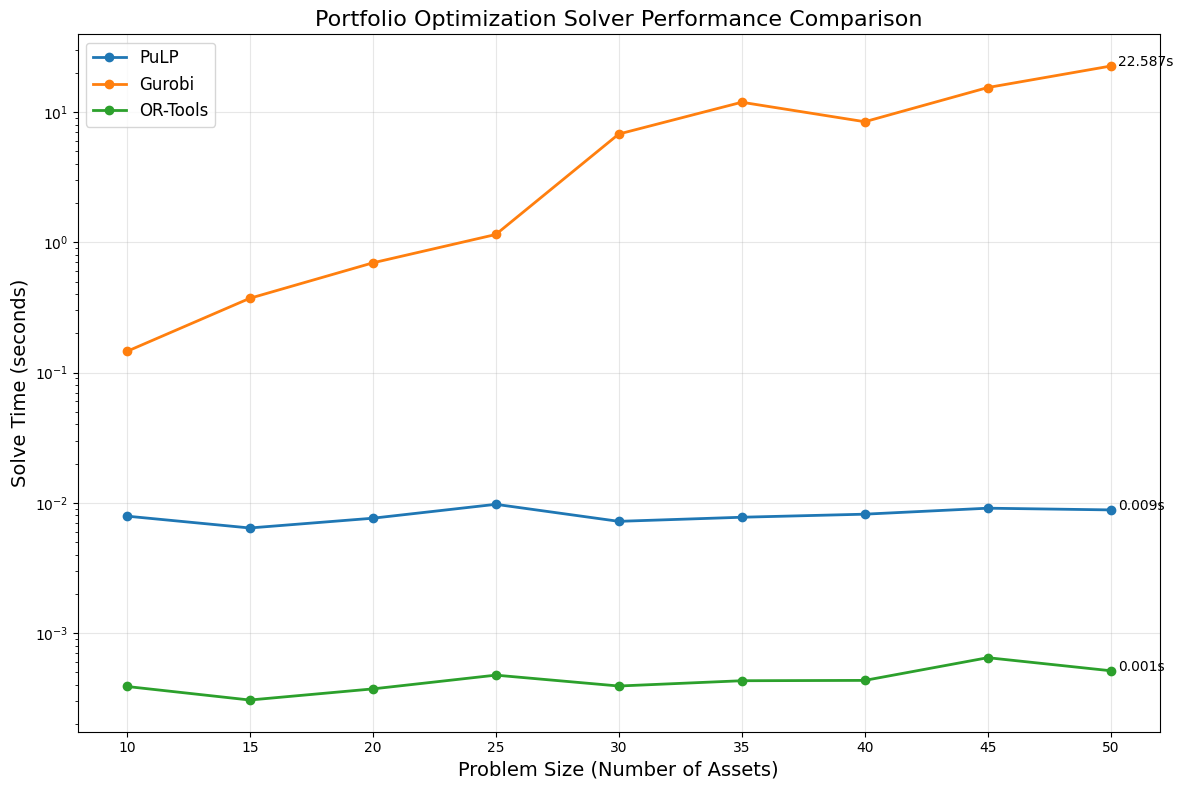

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Import solvers - with error handling for missing packages
try:
    import pulp as pl
    PULP_AVAILABLE = True
except ImportError:
    PULP_AVAILABLE = False
    print("PuLP not available. Install with: pip install pulp")

try:
    import gurobipy as gp
    GUROBI_AVAILABLE = True
except ImportError:
    GUROBI_AVAILABLE = False
    print("Gurobi not available. Install with: pip install gurobipy (license required)")

try:
    from ortools.linear_solver import pywraplp
    ORTOOLS_AVAILABLE = True
except ImportError:
    ORTOOLS_AVAILABLE = False
    print("Google OR-Tools not available. Install with: pip install ortools")

# ----------------------------
# PuLP Implementation
# ----------------------------
def optimize_with_pulp(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Portfolio optimization using PuLP (linear programming approach).
    """
    if not PULP_AVAILABLE:
        return {"status": "PuLP not installed", "solver": "PuLP", "solve_time": np.nan}

    n_assets = len(expected_returns)
    assets = range(n_assets)

    # Initialize problem
    prob = pl.LpProblem("Portfolio_Optimization", pl.LpMinimize)

    # Decision variables for asset weights
    weights = [pl.LpVariable(f"Asset_{i}", min_position, max_position) for i in assets]

    # Constraint: Sum of weights = 1
    prob += pl.lpSum(weights) == 1, "Sum_of_weights"

    # Create auxiliary variables for the absolute values of weights
    aux_vars = [pl.LpVariable(f"aux_{i}", 0, None) for i in assets]

    # Linear approximation of risk using the diagonal of covariance matrix
    risk_proxy = pl.lpSum([aux_vars[i] * np.sqrt(covariance_matrix[i, i]) for i in assets])

    # Set the auxiliary variables to be greater than or equal to the absolute values
    for i in assets:
        prob += aux_vars[i] >= weights[i], f"abs_constraint_pos_{i}"
        prob += aux_vars[i] >= -weights[i], f"abs_constraint_neg_{i}"

    # Minimize the risk proxy
    prob += risk_proxy, "Risk_Proxy"

    # Constraint: Achieve target return if specified
    if target_return is not None:
        prob += pl.lpSum([weights[i] * expected_returns[i] for i in assets]) >= target_return, "Target_Return"

    # Solve the optimization problem
    start_time = time.time()
    prob.solve(pl.PULP_CBC_CMD(msg=False))
    solve_time = time.time() - start_time

    # Process results
    if prob.status == 1:  # Optimal solution found
        return {
            "solver": "PuLP",
            "solve_time": solve_time,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found", "solver": "PuLP", "solve_time": solve_time}

# ----------------------------
# Gurobi Implementation
# ----------------------------
def optimize_with_gurobi(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Portfolio optimization using Gurobi (quadratic programming).
    """
    if not GUROBI_AVAILABLE:
        return {"status": "Gurobi not installed", "solver": "Gurobi", "solve_time": np.nan}

    n_assets = len(expected_returns)

    # Create a new model
    model = gp.Model("Portfolio_Optimization")
    model.setParam('OutputFlag', 0)  # Suppress output

    # Create variables for asset weights
    weights = model.addVars(n_assets, lb=min_position, ub=max_position, name="weights")

    # Constraint: Sum of weights = 1
    model.addConstr(gp.quicksum(weights[i] for i in range(n_assets)) == 1, "budget")

    # Constraint: Achieve target return if specified
    if target_return is not None:
        model.addConstr(gp.quicksum(weights[i] * expected_returns[i] for i in range(n_assets)) >= target_return, "return")

    # Set objective: Minimize portfolio variance (quadratic)
    obj = gp.QuadExpr()
    for i in range(n_assets):
        for j in range(n_assets):
            obj += weights[i] * covariance_matrix[i, j] * weights[j]

    model.setObjective(obj, gp.GRB.MINIMIZE)

    # Solve the model
    start_time = time.time()
    model.optimize()
    solve_time = time.time() - start_time

    # Process results
    if model.status == gp.GRB.OPTIMAL:
        return {
            "solver": "Gurobi",
            "solve_time": solve_time,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found", "solver": "Gurobi", "solve_time": solve_time}

# ----------------------------
# Google OR-Tools Implementation
# ----------------------------
def optimize_with_ortools(expected_returns, covariance_matrix, target_return=None, max_position=0.4, min_position=0):
    """
    Portfolio optimization using Google OR-Tools (linear programming approach).
    """
    if not ORTOOLS_AVAILABLE:
        return {"status": "OR-Tools not installed", "solver": "OR-Tools", "solve_time": np.nan}

    n_assets = len(expected_returns)
    assets = range(n_assets)

    # Create the solver
    solver = pywraplp.Solver.CreateSolver('GLOP')
    if not solver:
        return {"status": "Solver not available", "solver": "OR-Tools", "solve_time": np.nan}

    # Create variables for asset weights
    weights = [solver.NumVar(min_position, max_position, f'weight_{i}') for i in assets]

    # Constraint: Sum of weights = 1
    solver.Add(sum(weights) == 1)

    # Create auxiliary variables for the absolute values of weights
    aux_vars = [solver.NumVar(0, solver.infinity(), f'aux_{i}') for i in assets]

    # Set the auxiliary variables to be greater than or equal to the absolute values
    for i in assets:
        solver.Add(aux_vars[i] >= weights[i])
        solver.Add(aux_vars[i] >= -weights[i])

    # Linear approximation of risk
    risk_proxy = sum(aux_vars[i] * np.sqrt(covariance_matrix[i, i]) for i in assets)

    # Constraint: Achieve target return if specified
    if target_return is not None:
        portfolio_return = sum(weights[i] * expected_returns[i] for i in assets)
        solver.Add(portfolio_return >= target_return)

    # Minimize the risk proxy
    solver.Minimize(risk_proxy)

    # Solve the problem
    start_time = time.time()
    status = solver.Solve()
    solve_time = time.time() - start_time

    # Process results
    if status == pywraplp.Solver.OPTIMAL:
        return {
            "solver": "OR-Tools",
            "solve_time": solve_time,
            "status": "Optimal"
        }
    else:
        return {"status": "No feasible solution found", "solver": "OR-Tools", "solve_time": solve_time}

# ----------------------------
# Generate Random Test Data
# ----------------------------
def generate_test_data(n_assets, seed=42):
    """
    Generate random expected returns and covariance matrix for testing.
    """
    np.random.seed(seed)

    # Generate random expected returns (5% to 20%)
    expected_returns = np.random.uniform(0.05, 0.20, n_assets)

    # Generate random correlation matrix
    A = np.random.uniform(-1, 1, (n_assets, n_assets))
    corr_matrix = np.dot(A, A.T)
    # Ensure diagonal is 1
    np.fill_diagonal(corr_matrix, 1)
    # Normalize to ensure it's a valid correlation matrix
    D = np.diag(1.0 / np.sqrt(np.diag(corr_matrix)))
    corr_matrix = D @ corr_matrix @ D

    # Generate random volatilities (10% to 30%)
    volatilities = np.random.uniform(0.10, 0.30, n_assets)

    # Create covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix

    return expected_returns, cov_matrix

# ----------------------------
# Benchmark Function
# ----------------------------
def benchmark_solvers(problem_sizes, n_runs=1, target_return=0.10):
    """
    Benchmark solvers on different problem sizes.

    Parameters:
    -----------
    problem_sizes : list
        List of number of assets to test
    n_runs : int, default 3
        Number of runs for each problem size
    target_return : float, default 0.10
        Target return for the optimization

    Returns:
    --------
    pandas.DataFrame
        Benchmark results
    """
    results = []

    for n_assets in tqdm(problem_sizes, desc="Problem Sizes"):
        for run in range(n_runs):
            # Generate random test data
            expected_returns, cov_matrix = generate_test_data(n_assets, seed=run)

            # Run each solver
            pulp_result = optimize_with_pulp(
                expected_returns, cov_matrix, target_return=target_return
            )

            gurobi_result = optimize_with_gurobi(
                expected_returns, cov_matrix, target_return=target_return
            )

            ortools_result = optimize_with_ortools(
                expected_returns, cov_matrix, target_return=target_return
            )

            # Record results
            results.append({
                "problem_size": n_assets,
                "run": run,
                "solver": "PuLP",
                "solve_time": pulp_result["solve_time"],
                "status": pulp_result["status"]
            })

            results.append({
                "problem_size": n_assets,
                "run": run,
                "solver": "Gurobi",
                "solve_time": gurobi_result["solve_time"],
                "status": gurobi_result["status"]
            })

            results.append({
                "problem_size": n_assets,
                "run": run,
                "solver": "OR-Tools",
                "solve_time": ortools_result["solve_time"],
                "status": ortools_result["status"]
            })

    return pd.DataFrame(results)

# ----------------------------
# Plotting Function
# ----------------------------
def plot_benchmark_results(results_df):
    """
    Create a plot showing solve time vs problem size for each solver.
    """
    # Create a figure
    plt.figure(figsize=(12, 8))

    # Calculate average solve time for each problem size and solver
    avg_results = results_df.groupby(['problem_size', 'solver'])['solve_time'].mean().reset_index()

    # Plot solve time vs problem size for each solver
    for solver in ['PuLP', 'Gurobi', 'OR-Tools']:
        solver_data = avg_results[avg_results['solver'] == solver]
        plt.plot(solver_data['problem_size'], solver_data['solve_time'],
                 marker='o', linewidth=2, label=solver)

    # Add a log scale for y-axis if the time differences are large
    if avg_results['solve_time'].max() / avg_results['solve_time'].min() > 100:
        plt.yscale('log')

    # Add labels and title
    plt.xlabel('Problem Size (Number of Assets)', fontsize=14)
    plt.ylabel('Solve Time (seconds)', fontsize=14)
    plt.title('Portfolio Optimization Solver Performance Comparison', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Add annotations for the largest problem size
    max_problem_size = avg_results['problem_size'].max()
    for solver in ['PuLP', 'Gurobi', 'OR-Tools']:
        solver_data = avg_results[(avg_results['solver'] == solver) &
                                  (avg_results['problem_size'] == max_problem_size)]
        if not solver_data.empty:
            time_value = solver_data['solve_time'].values[0]
            plt.annotate(f"{time_value:.3f}s",
                        (max_problem_size, time_value),
                        textcoords="offset points",
                        xytext=(5, 0),
                        ha='left')

    plt.tight_layout()
    return plt

# ----------------------------
# Main Benchmark
# ----------------------------
if __name__ == "__main__":
    # Define problem sizes to test
    problem_sizes = np.arange(10,51,5)

    # Run benchmark
    print("Running benchmark...")
    results = benchmark_solvers(problem_sizes, n_runs=3)

    # Save results to CSV
    results.to_csv('portfolio_optimization_benchmark.csv', index=False)
    print(f"Results saved to portfolio_optimization_benchmark.csv")

    # Create and save plot
    plt = plot_benchmark_results(results)
    plt.savefig('portfolio_optimization_benchmark.png', dpi=300)
    print(f"Plot saved to portfolio_optimization_benchmark.png")

    # Display summary statistics
    print("\nSummary of solver performance:")
    avg_time = results.groupby(['solver', 'problem_size'])['solve_time'].mean().unstack()
    print(avg_time)

    # Check if any solvers were unavailable
    missing_solvers = []
    for solver in ['PuLP', 'Gurobi', 'OR-Tools']:
        if solver in results[results['status'].str.contains('not installed')]['solver'].unique():
            missing_solvers.append(solver)

    if missing_solvers:
        print(f"\nNote: The following solvers were not available: {', '.join(missing_solvers)}")
        print("Install them to get complete benchmark results.")

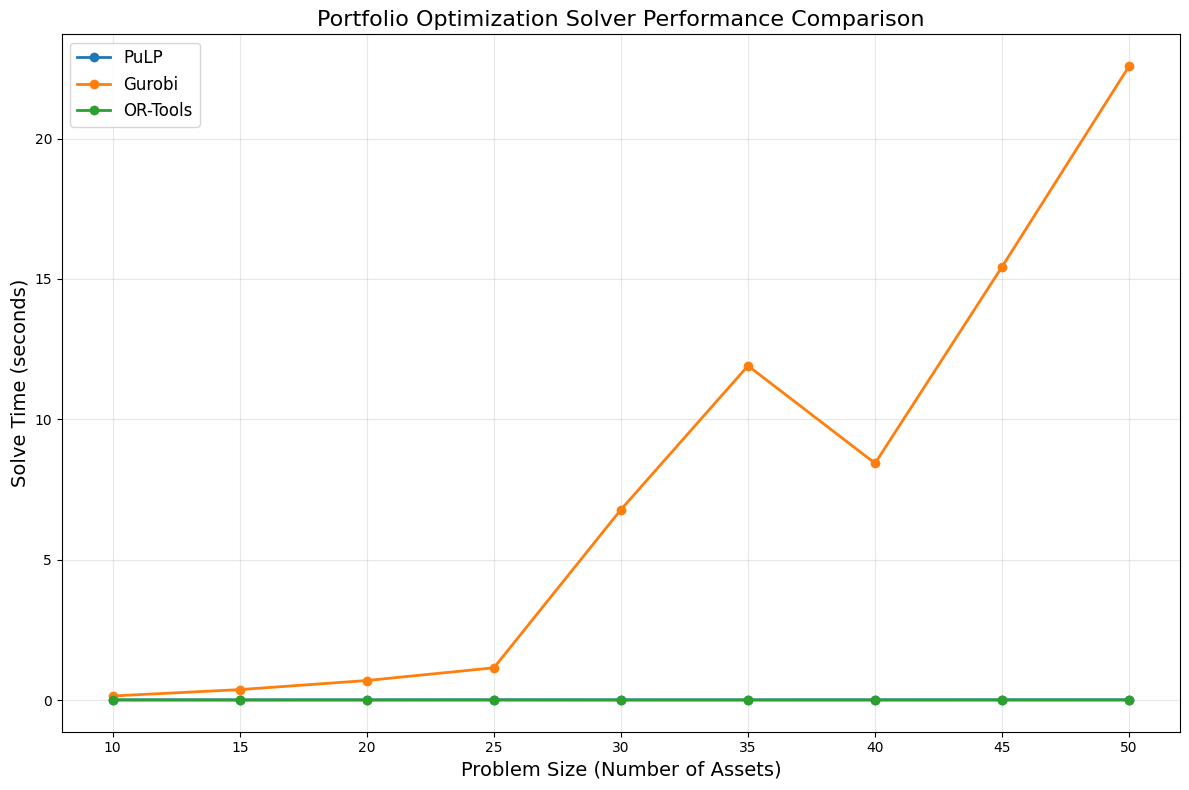

In [ ]:
def plot_benchmark_results1(results_df):
    """
    Create a plot showing solve time vs problem size for each solver.
    """
    # Create a figure
    plt.figure(figsize=(12, 8))

    # Calculate average solve time for each problem size and solver
    avg_results = results_df.groupby(['problem_size', 'solver'])['solve_time'].mean().reset_index()

    # Plot solve time vs problem size for each solver
    for solver in ['PuLP', 'Gurobi', 'OR-Tools']:
        solver_data = avg_results[avg_results['solver'] == solver]
        plt.plot(solver_data['problem_size'], solver_data['solve_time'],
                 marker='o', linewidth=2, label=solver)

    # # Add a log scale for y-axis if the time differences are large
    # if avg_results['solve_time'].max() / avg_results['solve_time'].min() > 100:
    #     plt.yscale('log')

    # Add labels and title
    plt.xlabel('Problem Size (Number of Assets)', fontsize=14)
    plt.ylabel('Solve Time (seconds)', fontsize=14)
    plt.title('Portfolio Optimization Solver Performance Comparison', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Add annotations for the largest problem size
    # max_problem_size = avg_results['problem_size'].max()
    # for solver in ['PuLP', 'Gurobi', 'OR-Tools']:
    #     solver_data = avg_results[(avg_results['solver'] == solver) &
    #                               (avg_results['problem_size'] == max_problem_size)]
    #     if not solver_data.empty:
    #         time_value = solver_data['solve_time'].values[0]
    #         plt.annotate(f"{time_value:.3f}s",
    #                     (max_problem_size, time_value),
    #                     textcoords="offset points",
    #                     xytext=(5, 0),
    #                     ha='left')

    plt.tight_layout()
    return plt
plt = plot_benchmark_results1(results)